In [1]:
!nvidia-smi

Thu Nov 28 17:01:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000004:04:00.0 Off |                    0 |
| N/A   42C    P0              54W / 184W |  13544MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
from torchvision import datasets, transforms

tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

import os
try_data_dirs = ['/home/zhh/data','/home/zhh24/data']
for data_dir in try_data_dirs:
    if os.path.exists(data_dir):
        break
assert os.path.exists(data_dir), 'data_dir does not exist'

batch_size = 512
train_dataset = datasets.MNIST(root = data_dir,
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = data_dir,
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)

In [3]:
class Avger(list):
    def __str__(self):
        return f'{sum(self) / len(self):.4f}' if len(self) > 0 else 'N/A'
    
from tqdm.notebook import tqdm,trange
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# from vanilla_unet import UNet as ModelCls

In [5]:
class BatchPrepareBase:
    def process(self, x):
        raise NotImplementedError

In [6]:
import os
import torchvision.utils as vutils
from tqdm import trange

class SamplerBase:
    def __init__(self):
        os.makedirs('samples', exist_ok=True)
        os.makedirs('checkpoints', exist_ok=True)
        
    def calc(self, model, num):
        raise NotADirectoryError()
    
    @torch.no_grad()
    def sample(self, model, num, desc):
        x = self.calc(model, num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}.png')
        torch.save(model.state_dict(), f'checkpoints/{desc}.pth')
        

In [4]:
from IPython.display import Image, display

In [8]:
assert False

AssertionError: 

# Conditional PixelCNN sanity

In [ ]:
from pixelcnn import PixelCNNContinous_cond

In [ ]:
from math import pi
class PixelCNN_C_BatchPrep(BatchPrepareBase):
    @staticmethod
    def gaussian_log_pdf(x, mu, logvar):
        # print('type',type(x),type(mu),type(logvar))
        # print(x.shape,mu.shape,logvar.shape)
        assert x.shape == mu.shape == logvar.shape
        var = torch.exp(logvar)
        return -0.5 * (torch.log(2 * torch.tensor(pi)) + logvar +((x - mu) ** 2) / var)
    
    def process(self, x, label):
        noisy = (x + torch.randn_like(x)) / 2
        # noisy = (x + torch.randn_like(x)) / torch.sqrt(torch.tensor(2.0))
        # return noisy.cuda(), label.cuda()
        return noisy, label
    
class PixelCNN_C_Sampler(SamplerBase):
    def calc(self,model,num):
        x = torch.randn(num, 1, 28, 28)
        label = torch.arange(10).repeat(num//10+1).reshape(-1)[:num].long()
        # x = torch.randn(num, 1, 28, 28).cuda()
        for i in trange(28):
            for j in range(28):
                mu, logvar = model(x,label)
                x[:, :, i, j] = torch.normal(mu[:, :, i, j], torch.exp(logvar[:, :, i, j]/2)).cpu()
        return x
        

In [ ]:
from tqdm import tqdm
class PixelCNN_Trainer:
    def __init__(self, model, epochs,lr,desc,preparer:PixelCNN_C_BatchPrep,sampler:SamplerBase, sample_ep=4):
        self.model = model
        self.epochs = epochs
        self.sample_ep = sample_ep
        self.lr = lr
        self.preparer = preparer
        self.sampler = sampler
        self.desc = desc
        
    def run(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            # opt.param_groups[0]['lr'] = self.lr * (1-epoch/self.epochs)
            self.model.train()
            train_loss = Avger()
            with tqdm(train_loader) as bar:
                for x,y in bar:
                    inputs = self.preparer.process(x,y)
                    pred = self.model(*inputs)
                    loss = -self.preparer.gaussian_log_pdf(inputs[0].cuda(), pred[0], pred[1]).mean()
                    
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    train_loss.append(loss.item())
                    bar.set_description(f'Epoch {epoch+1}/{self.epochs}, loss={train_loss}')
                    # break
                    
            if epoch == 0 or (epoch + 1) % self.sample_ep == 0 or epoch == self.epochs - 1:
                self.model.eval()
                self.sampler.sample(self.model, 64, f'ep{epoch+1}_{self.desc}')
                print(f'Epoch {epoch+1}, sample saved')

num of model parameters: 1997058


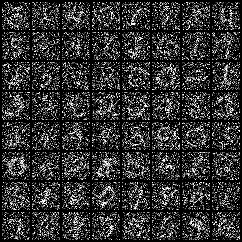

In [ ]:
model = PixelCNNContinous_cond().cuda()
model = nn.DataParallel(model)
print('num of model parameters:', sum(p.numel() for p in model.parameters()))
preparer = PixelCNN_C_BatchPrep()
# visualize a noisy batch
x,y = next(iter(train_loader))
x = x[:64]; y = y[:64]
noisy = preparer.process(x, y)[0]
grid = vutils.make_grid(noisy, nrow=8)
vutils.save_image(grid, 'samples/noisy.png')
display(Image('samples/noisy.png'))

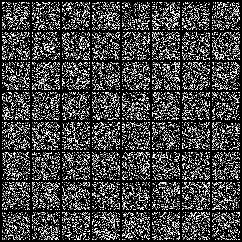

In [ ]:
noise = torch.randn(64, 1, 28, 28)
grid = vutils.make_grid(noise, nrow=8)
vutils.save_image(grid, 'samples/noise.png')
from IPython.display import Image, display
display(Image('samples/noise.png'))

In [ ]:
model = PixelCNNContinous_cond().cuda()
model = nn.DataParallel(model)
trainer = PixelCNN_Trainer(model, 50, 1e-4, 'pixelcnn_cond', preparer, PixelCNN_C_Sampler())
trainer.run()

  0%|                                                                                                                                                                               | 0/118 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:12<00:00,  2.21it/s]


Epoch 1, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:12<00:00,  2.21it/s]


Epoch 4, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:12<00:00,  2.21it/s]


Epoch 8, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:12<00:00,  2.21it/s]


Epoch 12, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:12<00:00,  2.21it/s]


Epoch 16, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:12<00:00,  2.21it/s]


Epoch 20, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:12<00:00,  2.21it/s]


Epoch 24, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:12<00:00,  2.21it/s]


Epoch 28, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:12<00:00,  2.21it/s]


Epoch 32, sample saved


Epoch 33/50, loss=0.7489:  30%|█████████████████████████████████████████▌                                                                                                  | 35/118 [00:05<00:12,  6.79it/s]


KeyboardInterrupt: 

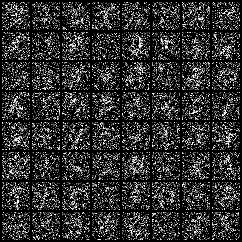

In [ ]:
display(Image('./samples/ep32_pixelcnn_cond.png'))

# VAE with noise

In [9]:
class SanityVAE_BatchPrep(BatchPrepareBase):
    def process(self, x):
        return x.cuda()
        
class NoiseVAE_BatchPrep(BatchPrepareBase):
    def process(self, x):
        # noise = torch.randn_like(x)
        return ((x )/torch.sqrt(torch.tensor(2.))).cuda()
        

In [10]:
class VAE_Sampler(SamplerBase):

    def calc(self,model,num):
        return model.decode(torch.randn(num, model.latent_dim).cuda())
    
    @torch.no_grad()
    def sample(self, model, num, desc):
        x_data = next(iter(test_loader))[0][:num].cuda()
        
        # generation
        x = self.calc(model, num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_gen.png')
        
        # reconstruction
        
        mu, logvar = model.encode(x_data)
        x_recon = model.decode(mu+torch.randn_like(mu)*torch.exp(logvar/2))
        grid = vutils.make_grid(x_recon, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_recon.png')
        grid = vutils.make_grid(x_data, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_data.png')
        
        torch.save(model.state_dict(), f'checkpoints/{desc}.pth')
        

In [11]:
from tqdm import tqdm
class VAE_trainer:
    def __init__(self, model, epochs,lr,desc,preparer:BatchPrepareBase,sampler:SamplerBase, sample_ep=4):
        self.model = model
        self.epochs = epochs
        self.sample_ep = sample_ep
        self.lr = lr
        self.preparer = preparer
        self.sampler = sampler
        self.desc = desc
        
    def run(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            # opt.param_groups[0]['lr'] = self.lr * (1-epoch/self.epochs)
            self.model.train()
            train_loss = Avger(); rec_loss = Avger(); kl_loss = Avger()
            
            with tqdm(train_loader) as bar:
                for x,_ in bar:
                    inputs = self.preparer.process(x)
                    loss, rec, kl = self.model(inputs)
                    
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    train_loss.append(loss.item()); rec_loss.append(rec.item()); kl_loss.append(kl.item())
                    bar.set_description(f'Epoch {epoch+1}/{self.epochs}, loss={train_loss}, rec={rec_loss}, kl={kl_loss}')
                    # break
                    
            if epoch == 0 or (epoch + 1) % self.sample_ep == 0 or epoch == self.epochs - 1:
                self.model.eval()
                self.sampler.sample(self.model, 64, f'ep{epoch+1}_{self.desc}')
                print(f'Epoch {epoch+1}, sample saved')

In [12]:
from vae import noiseVAE
model = noiseVAE().cuda()
print('number of parameters:', sum(p.numel() for p in model.parameters()))
trainer = VAE_trainer(model, 50, 1e-3, 'sanity', NoiseVAE_BatchPrep(), VAE_Sampler())
trainer.run()

number of parameters: 944600


Epoch 1/50, loss=27.0429, rec=26.9024, kl=0.1405: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.53it/s]


Epoch 1, sample saved


Epoch 4/50, loss=22.9380, rec=20.6028, kl=2.3352: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.87it/s]


Epoch 4, sample saved


Epoch 8/50, loss=20.7141, rec=16.8624, kl=3.8517: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.87it/s]


Epoch 8, sample saved


Epoch 9/50, loss=20.4402, rec=16.4372, kl=4.0030: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.87it/s]
Epoch 10/50, loss=20.2235, rec=16.0676, kl=4.1559: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.85it/s]
Epoch 11/50, loss=20.0633, rec=15.8349, kl=4.2284: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.86it/s]
Epoch 12/50, loss=19.9511, rec=15.6343, kl=4.3168: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.86it/s]


Epoch 12, sample saved


Epoch 13/50, loss=19.8124, rec=15.4555, kl=4.3569: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.90it/s]
Epoch 14/50, loss=19.7632, rec=15.3364, kl=4.4267: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.85it/s]
Epoch 15/50, loss=19.6940, rec=15.2213, kl=4.4727: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.91it/s]
Epoch 16/50, loss=19.6313, rec=15.1204, kl=4.5109: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.89it/s]


Epoch 16, sample saved


Epoch 17/50, loss=19.5768, rec=15.0349, kl=4.5418: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.86it/s]
Epoch 18/50, loss=19.5123, rec=14.9293, kl=4.5830: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.87it/s]
Epoch 19/50, loss=19.4821, rec=14.8635, kl=4.6187: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.85it/s]
Epoch 20/50, loss=19.4347, rec=14.7849, kl=4.6497: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.88it/s]


Epoch 20, sample saved


Epoch 21/50, loss=19.3860, rec=14.7091, kl=4.6770: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.86it/s]
Epoch 22/50, loss=19.3570, rec=14.6571, kl=4.6999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.88it/s]
Epoch 23/50, loss=19.3322, rec=14.6145, kl=4.7177: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.89it/s]
Epoch 24/50, loss=19.3254, rec=14.5824, kl=4.7430: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.83it/s]


Epoch 24, sample saved


Epoch 25/50, loss=19.2700, rec=14.5020, kl=4.7680: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.87it/s]
Epoch 26/50, loss=19.2239, rec=14.4357, kl=4.7882: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.86it/s]
Epoch 27/50, loss=19.2170, rec=14.4106, kl=4.8064: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.89it/s]
Epoch 28/50, loss=19.2092, rec=14.3817, kl=4.8275: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.87it/s]


Epoch 28, sample saved


Epoch 29/50, loss=19.1744, rec=14.3344, kl=4.8400: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.87it/s]
Epoch 30/50, loss=19.1744, rec=14.2993, kl=4.8751: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.83it/s]
Epoch 31/50, loss=19.1184, rec=14.2366, kl=4.8818: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.87it/s]
Epoch 32/50, loss=19.1113, rec=14.2082, kl=4.9030: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.84it/s]


Epoch 32, sample saved


Epoch 33/50, loss=19.1144, rec=14.1949, kl=4.9195: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.85it/s]
Epoch 34/50, loss=19.0522, rec=14.1189, kl=4.9333: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.87it/s]
Epoch 35/50, loss=19.0626, rec=14.1248, kl=4.9378: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.87it/s]
Epoch 36/50, loss=19.0369, rec=14.0625, kl=4.9744: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.84it/s]


Epoch 36, sample saved


Epoch 37/50, loss=18.9966, rec=14.0351, kl=4.9615: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.84it/s]
Epoch 38/50, loss=18.9889, rec=13.9963, kl=4.9926: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.87it/s]
Epoch 39/50, loss=18.9778, rec=13.9696, kl=5.0082: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.84it/s]
Epoch 40/50, loss=18.9795, rec=13.9602, kl=5.0192: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 11.90it/s]


Epoch 40, sample saved


Epoch 41/50, loss=18.9179, rec=13.8492, kl=5.0687:  43%|█████████████████████████████████████████████████▋                                                                 | 51/118 [00:04<00:05, 11.65it/s]


KeyboardInterrupt: 

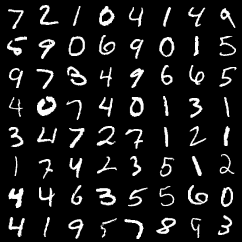

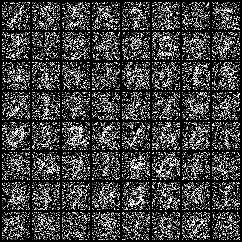

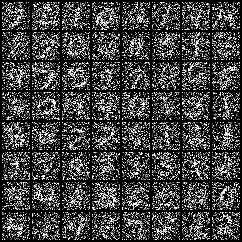

In [7]:
display(Image('./samples/ep40_sanity_data.png'))
display(Image('./samples/ep40_sanity_gen.png'))
display(Image('./samples/ep40_sanity_recon.png'))